# Exercises

### Q1. What are the main motivations for reducing a dataset's dimensionality? What are the main drawbacks?

- The main motivation to reduce a dataset's dimensionality is to reduce the dataset size which can lead to faster computation of models. Dimensionality redcution can also be useful to bring a high-dimensional data down to 2 or 3 dimensions for visualization.

- The drawbacks of dimensionality reduction could be losing some information from the data. Also the reduced features may be hard to interprete.

### Q2. What is the curse of dimensionality?

- Points that are at a medium distance in a high dimensional space when projected to a low dimensional space may become too crowded since there is a lot less room. 
- So all the points get squashed in the lower dimensional space causing crowding.

### Q3. Once a dataset's dimensionality has been reduced, is it possible to reverse the operation? If so, how? If not, why?

- Only some algorithms make it possible to reverse the operation and get the original data back. However, the reproduced data would not be the same original data but a quite close representation of the orginal data. This is because some information is lost during the dimensionality reduction process.

- scikit-learn comes with *..inverse_transform()* function to reverse the operation.

### Q4. Can PCA be used to reduce the dimensionality of a highly non-linear dataset?

- PCA is a linear projection algorithm. Reducing the dimensions of a highly non-linear dataset is possible with PCA as it can still get rid of useless dimensions. But if there are no useless dimensions then PCA isn't advisable since it will lose a lot of information.

### Q5. Suppose you perform PCA on a 1000 dimensional dataset, setting the explained variance ratio to 95%. How many dimensions will the resulting dataset have?

- The dimensions of the resulting dataset will depend on the type of data. If it is highly non-linear then many PCs would be required to preserve the 95% variance.

- Plotting the explained variance as a function of number of dimensions is one way to get a rough idea of dataset's intrinsic dimensionality.

### Q6. In what cases would you use vanilla PCA, Incremental PCA, Randomized PCA or Kernel PCA?

- Vanilla PCA can be used if the size of the dataset is small and can fit in the memory.
- Incremental PCA could be used for a huge dataset so that the PCA can be computed for mini-batches rather than on the entire dataset altogether. It can also be computed online (on the fly when new instances arrive).
- Randomized PCA is useful when we want to considerably reduce dimensionality and the dataset fits in memory; it is much faster than vanilla PCA.
- Kernel PCA is useful when the data is non-linear.

### Q7. How can you evaluate the performance of a dimensionality reduction algorithm on your dataset?

- There are two main approaches:
    - Dimensionality reduction is often used a pre step for supervised learning tasks like classification or regression. So the dimensionality reduction step can be added to the pipeline and then algorithm could be trained. Hyperparameters of the reduction algorithm can be fine-tuned with GridSearchCV to get the best set of parameters which gives the lowest loss.
    - Another approach is totally unsupervised. In this case the reverse transformation is applied and the reconstruction error is measured. However, not all algorithms provide to do reverse transformations.

### Q8. Does it make any sense to chain two different dimensionality reduction algorithms?

- It does. A common example is to use PCA first to get rid of useless dimensions. Then applying much slower dimensionality reduction techniques like LLE.

### Q9. MNIST

In [1]:
# imports
import numpy as np
import time

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

In [4]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [5]:
# training a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10, random_state=42)

t0 = time.time()
forest.fit(X_train, y_train)
t1 = time.time()

print(f"Training Time : {t1 - t0:.2f}s")

Training Time : 5.31s


In [6]:
# evaluating on test set
y_pred = forest.predict(X_test)
accuracy_score(y_test, y_pred)

0.9492

In [7]:
# use PCA to reduce dimensionality with an explained variance ratio of 95%
pca = PCA(n_components=0.95, random_state=42)
X_train_reduced = pca.fit_transform(X_train)

In [8]:
# training the reduced data with Random Forest
forest2 = RandomForestClassifier(n_estimators=10, random_state=42)

t0 = time.time()
forest2.fit(X_train_reduced, y_train)
t1 = time.time()

print(f"Training Time : {t1-t0:.2f}s")

Training Time : 11.51s


#### Was training faster?

- It was actually slower. As discussed in the book dimensionality reduction algorithms are not always faster. It depends on the dataset, the model and the training algorithm.

In [9]:
# Evaluation
X_test_reduced = pca.transform(X_test)

y_pred = forest2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9009

PCA here did not help. It slowed down training as well as reduced the performance.

#### Repeating the entire process with softmax regression

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
log_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)

t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

print(f"Training took {t1-t0:.2f}s")

Training took 17.45s


/home/paperspace/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [12]:
# Evaluating
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

In [13]:
log_clf2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)

t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

print(f"Training took {t1-t0:.2f}s")

Training took 8.71s


/home/paperspace/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The training with reduced dataset was much faster than original!

In [14]:
# Evaluating
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

A very slight drop in the performance, which is reasonable given the algorithm runs much faster depending on the application.

**Takeaway :** PCA can give a formidable speedup...but not always!

### Q 10.

In [20]:
# t-SNE to reduce MNIST down to two dimensions
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [17]:
tsne = TSNE(n_components=2, random_state=42)
X_train_reduced = tsne.fit_transform(X)

In [27]:
y

array(['3', '8', '3', ..., '1', '8', '4'], dtype=object)

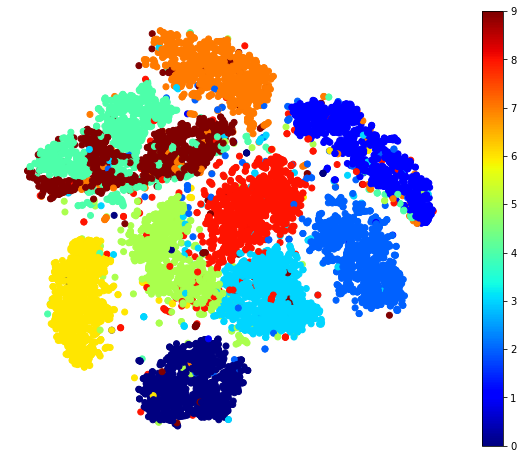

In [29]:
plt.figure(figsize=(10, 8))
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y.astype(int), cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

In [31]:
# trying other dimensionality reduction techniques
## PCA

In [32]:
t0 = time.time()
pca = PCA(n_components=2, random_state=42)
X_pca_reduced = pca.fit_transform(X)
t1 = time.time()

print(f"Training with PCA took {t1-t0:.2f}s")

Training with PCA took 0.33s


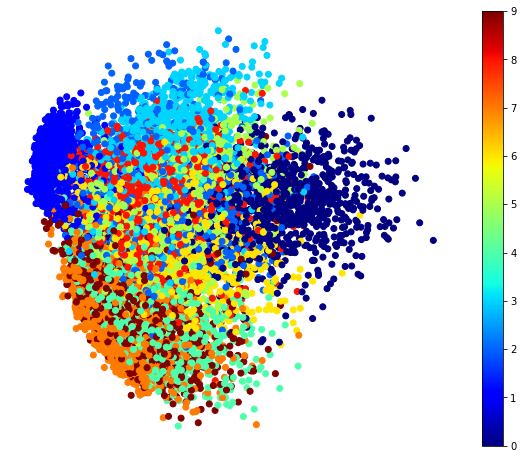

In [33]:
plt.figure(figsize=(10, 8))
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y.astype(int), cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

PCA is fast but the clusters are too overlapping.

In [34]:
# LLE
from sklearn.manifold import LocallyLinearEmbedding

In [35]:
t0 = time.time()
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_lle_reduced = lle.fit_transform(X)
t1 = time.time()

print(f"Training with LLE took {t1-t0:.2f}s")

Training with LLE took 175.20s


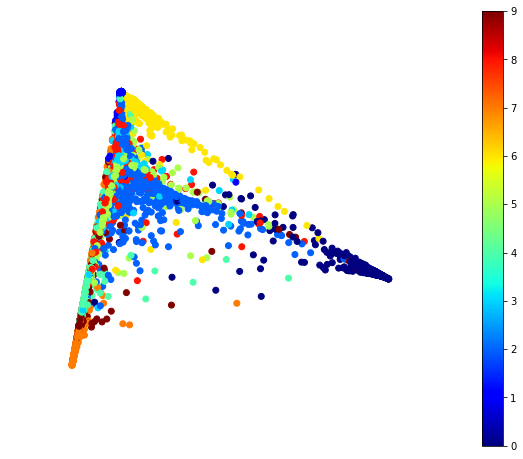

In [36]:
plt.figure(figsize=(10, 8))
plt.scatter(X_lle_reduced[:, 0], X_lle_reduced[:, 1], c=y.astype(int), cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

In [37]:
# timing t-SNE and then seeing if it can faster if PCA is applied first
t0 = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_tsne_reduced = tsne.fit_transform(X)
t1 = time.time()

print(f"TSNE took {t1-t0: .2f}s")

TSNE took  259.68s


t-sne takes very long. Way longer than LLE

In [38]:
# PCA + t-SNE
from sklearn.pipeline import Pipeline

In [39]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42))
])

to = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()

print(f"PCA + t-SNE took {t1 - t0: .2f}s")

PCA + t-SNE took  534.58s


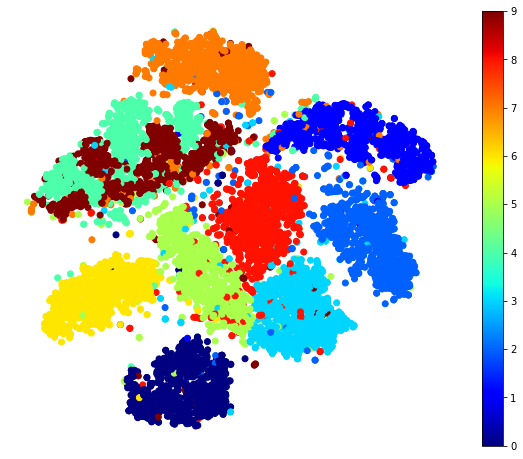

In [40]:
plt.figure(figsize=(10, 8))
plt.scatter(X_pca_tsne_reduced[:, 0], X_pca_tsne_reduced[:, 1], c=y.astype(int), cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()